# Bangumi个人记录

## 导入分析库

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

## 已看番剧云词图
### 1. 相关函数

In [2]:
def get_html_content_in_text(url):
    """
    Grab all the content in webpage url and return it's content in text.
    
    Arguments:
    url -- a webpage url string.
    
    Returns:
    r.text -- the content of webpage in text.
    
    """
    r = requests.get(url)
    r.encoding = r.apparent_encoding
    return r.text

In [3]:
def get_title(soup):
    """
    Grab all the Chinese title and Japanese title.
    
    Arguments:
    soup -- a BeautifulSoup object.
    
    Returns:
    title_chinese -- a list of title in chinese.
    title_japanese -- a list of title in japanses.
    
    """
    title = soup.find_all('h3')
    title_chinese = []
    title_japanese = []
    for i in title:
        if i.a and i.small:
            title_chinese.append(i.a.string)
            title_japanese.append(i.small.string)
        else:
            if i.a:
                title_chinese.append(i.a.string)
                title_japanese.append('None')
            else:
                title_chinese.append('None')
                title_japanese.append(i.small.string)
    return title_chinese, title_japanese

In [4]:
def get_star(soup):
    """
    Grab all the star.
    
    Arguments:
    soup -- a BeautifulSoup object.
    
    Returns:
    star_count -- a list of star value.
    
    """
    star_list = soup.find_all(class_='collectInfo')
    star_count = []
    for star in list(star_list):
        star_search = re.search(r'sstars(.*) starsinfo',str(star), re.IGNORECASE)
        if star_search:
            star_count.append(int(star_search.group(1)))
        else:
            star_count.append(None)
    return star_count

In [5]:
def make_wordcloud_plot(df, word_column, value_column, colormap='plasma'):
    d = df.to_dict('index')
    dict_for_plot = {}
    for i in d.values():
        try:
            dict_for_plot[i[word_column]] = int(i[value_column])
        except ValueError:
            pass
    
    font = r'C:\Windows\Fonts\SimHei.ttf'
    wordcloud = WordCloud(font_path=font, 
                          width=1400, 
                          height=1400, 
                          background_color='white',
                          max_words=2000,
                          max_font_size=50, 
                          colormap=colormap,
                          mode='RGBA').fit_words(dict_for_plot)
    
    plt.figure(figsize=(25,25))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

### 2. 拉取记录

In [6]:
title_chinese_total = []
title_japanese_total = []
star_count_total = []

i = 1
print('正在获取页面记录：')
while True:
    content = get_html_content_in_text('http://bangumi.tv/anime/list/infinityloop/collect?page='+str(i))
    soup = BeautifulSoup(content, "html5lib")

    title_chinese, title_japanese = get_title(soup)
    star_count = get_star(soup)

    if len(title_chinese) != 0:
        print(i,' ', end='')
        title_chinese_total.extend(title_chinese)
        title_japanese_total.extend(title_japanese)
        star_count_total.extend(star_count)
        i += 1
    else:
        break

正在获取页面记录：
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  

In [7]:
df = pd.DataFrame({'chinese':title_chinese_total, 'japanese':title_japanese_total, 'star':star_count_total})
df.head(10)

,chinese,japanese,star
0,OVERLORD II,オーバーロードII,8.0
1,食戟之灵 餐之皿,食戟のソーマ 餐ノ皿,8.0
2,pop子和pipi美的日常,ポプテピピック,7.0
3,刻刻,刻刻,8.0
4,为离别之朝饰上约定之花,さよならの朝に約束の花をかざろう,9.0
5,剧场版 中二病也要谈恋爱！ -Take On Me-,映画 中二病でも恋がしたい！ -Take On Me-,8.0
6,奇诺之旅,キノの旅 -the Beautiful World- the Animated Series,7.0
7,干物妹！小埋R,干物妹! うまるちゃんR,5.0
8,少女周末授课,少女週末授業,NaN
9,Just Because!,None,8.0


### 3. 数据整理

In [8]:
df.loc[df['japanese'] == 'None', 'chinese'] = df.chinese
df.loc[df['chinese'] == 'None', 'japanese'] = df.japanese

### 4. 绘图

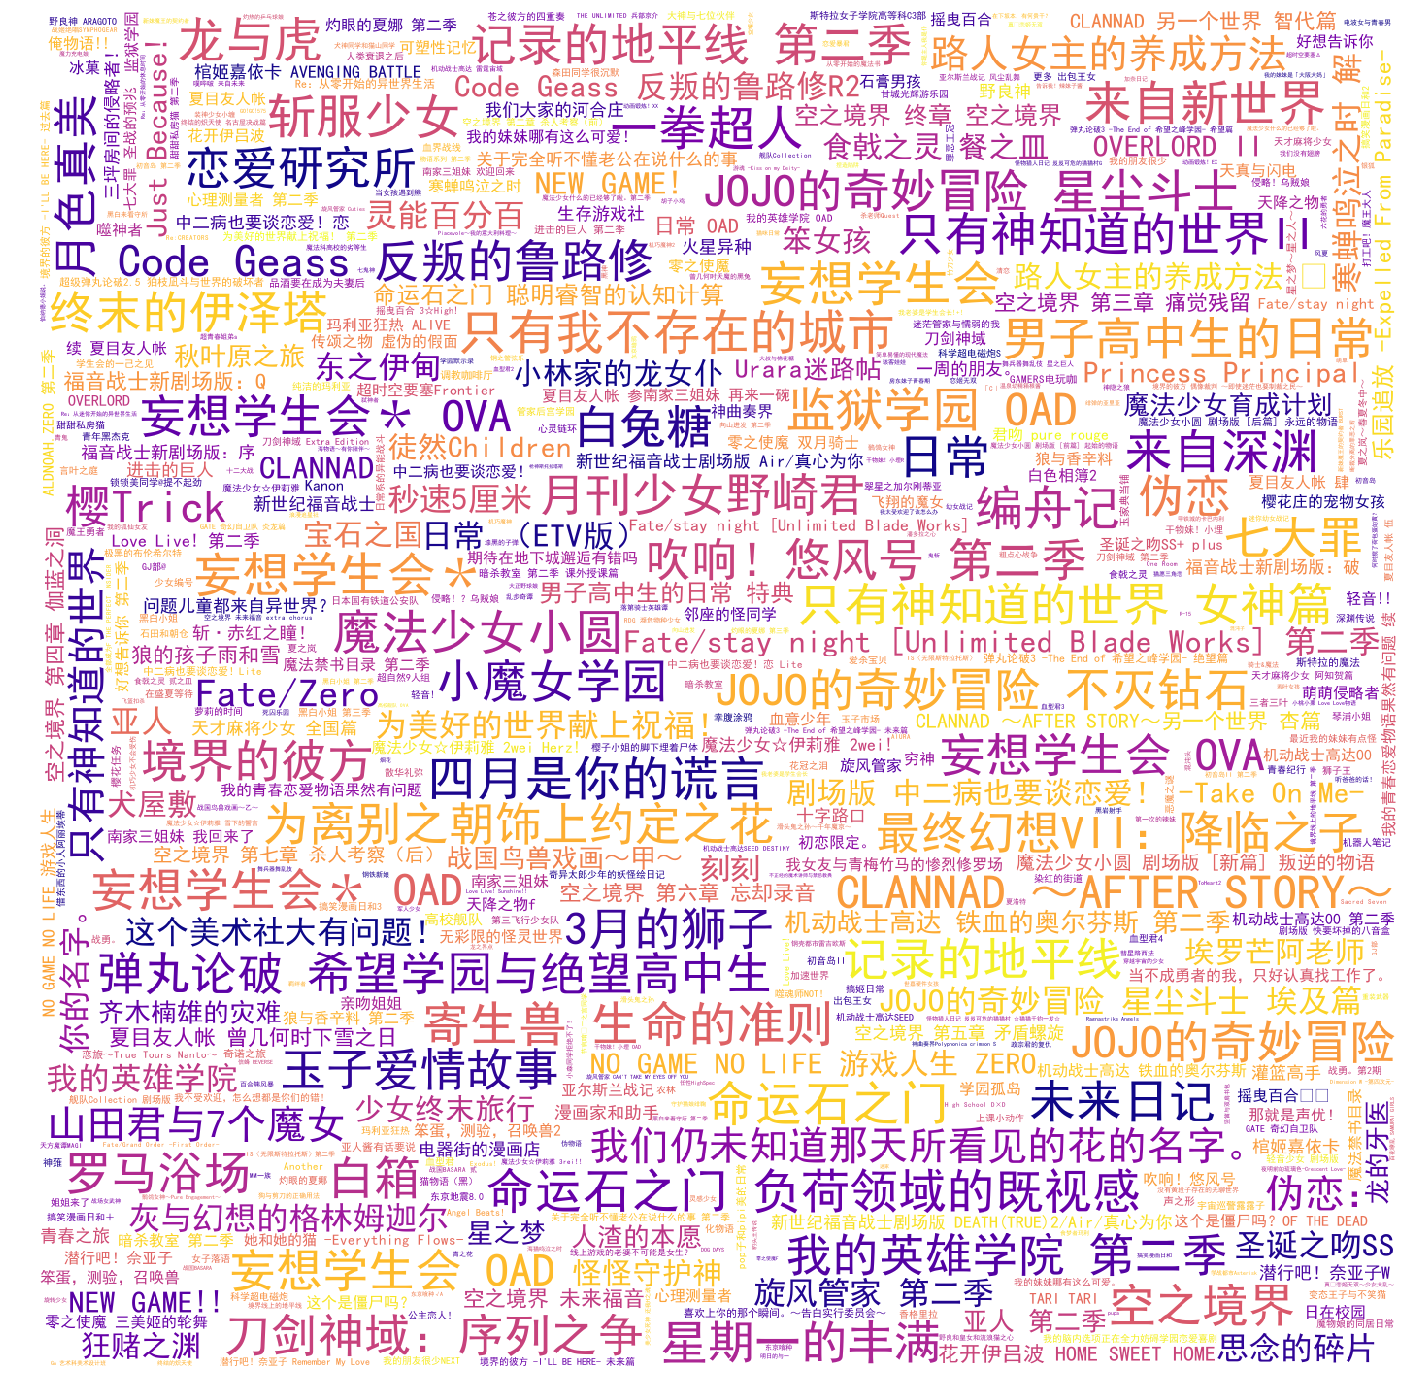

In [9]:
make_wordcloud_plot(df, 'chinese', 'star', colormap='plasma')

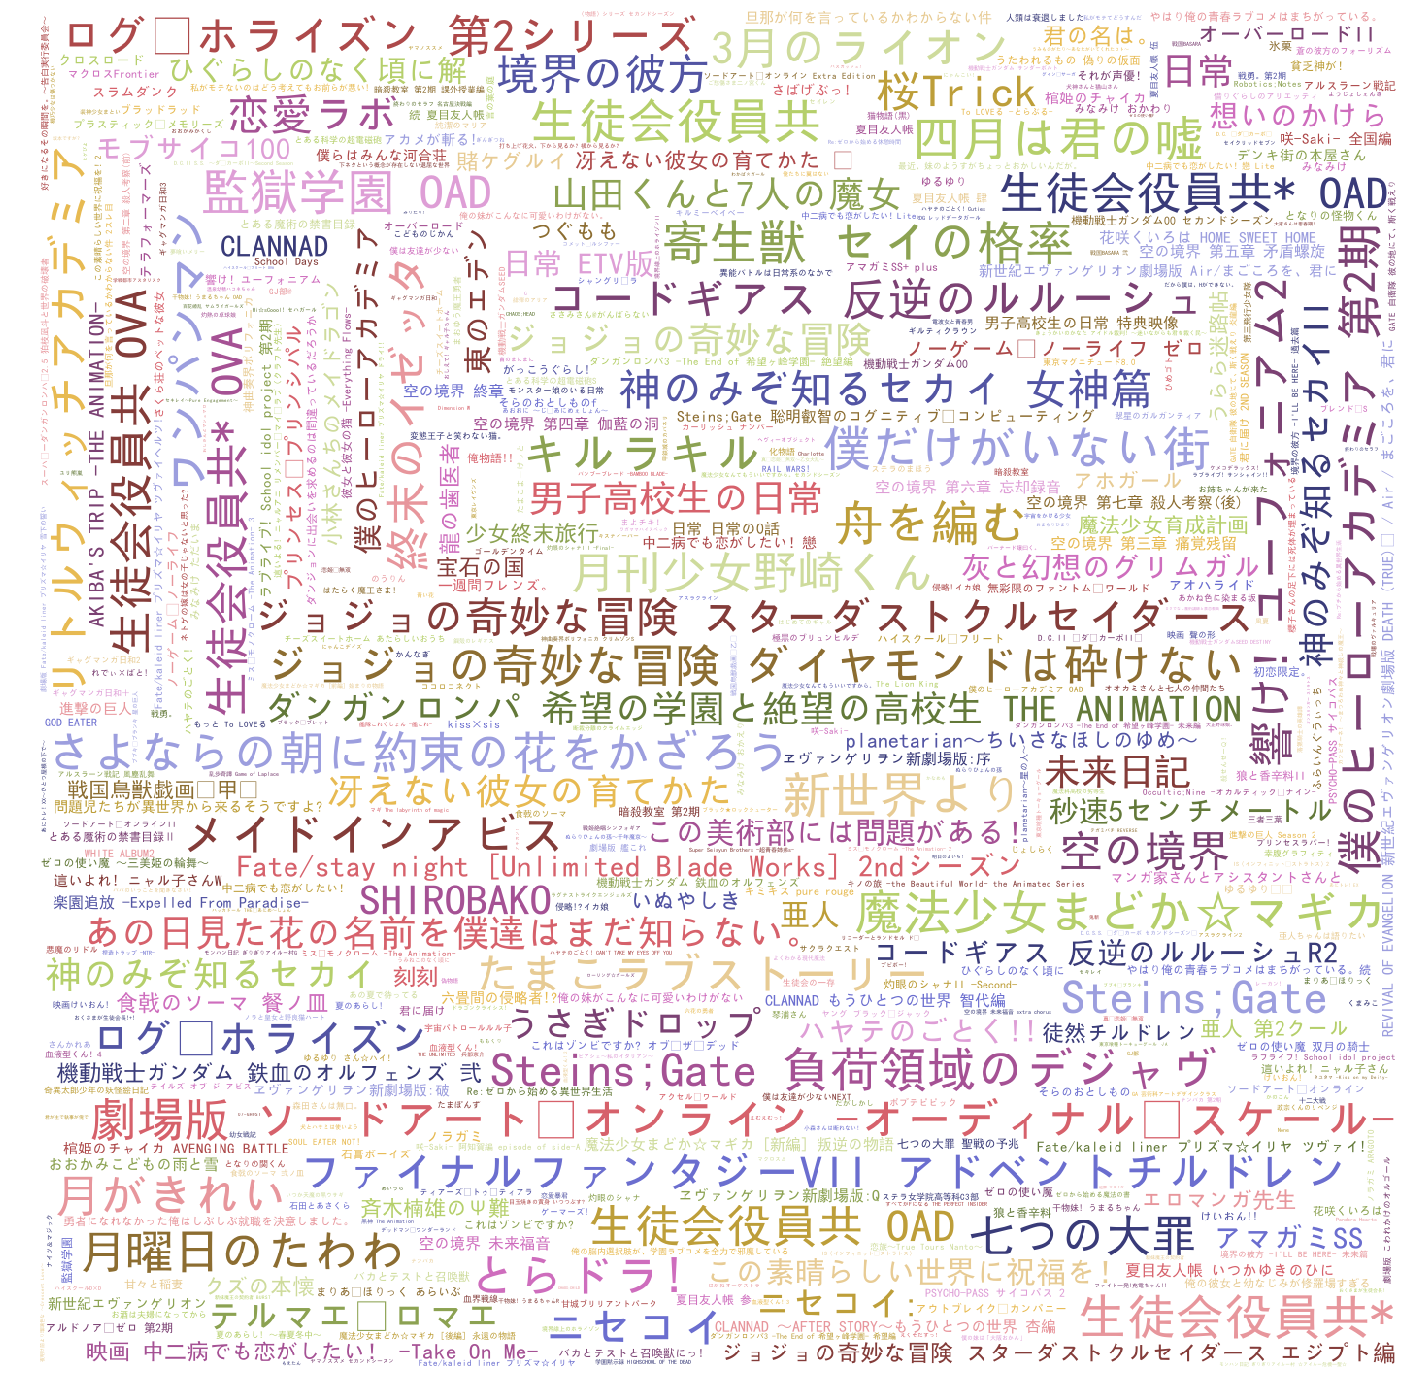

In [10]:
make_wordcloud_plot(df, 'japanese', 'star', colormap='tab20b')

## 评分分布

In [11]:
star_dist = df.groupby('star').count()
star_dist['percentage'] = round(star_dist.chinese/len(df)*100, 2)
star_dist['percentage'] = star_dist.percentage.apply(lambda x: str(x)+'%')
star_dist

,chinese,japanese,percentage
star,,,
4.0,6,6,1.01%
5.0,70,70,11.8%
6.0,122,122,20.57%
7.0,144,144,24.28%
8.0,158,158,26.64%
9.0,62,62,10.46%
10.0,16,16,2.7%


In [17]:
py.offline.init_notebook_mode(connected=True)

data = [go.Bar(
            x=star_dist.index,
            y=star_dist.chinese,
    text=star_dist.percentage
    )]

layout = go.Layout(
    title='评分分布情况',
    xaxis=dict(
        title='分数'
    ),
    yaxis=dict(
        title='动画部数'
    )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='jupyter/basic_bar')

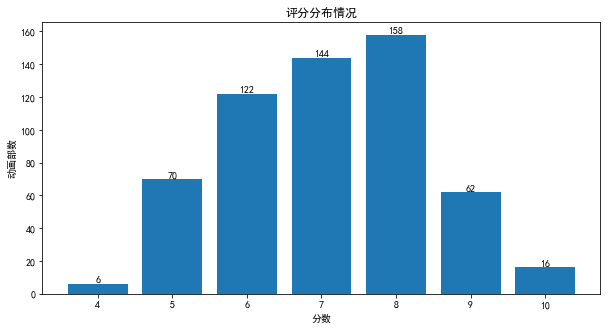

In [52]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False 
plt.bar(star_dist.index, star_dist.chinese)

plt.ylabel('动画部数')
plt.xlabel('分数')
plt.title('评分分布情况')
plt.rcParams['figure.figsize'] = [10,5]

for a,b in zip(star_dist.index, star_dist.chinese):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom')
    
plt.show()